# This notebook is to build methods to quantify network quality

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
import community
import netrd
import time
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.pyplot as plt
%matplotlib inline

# Evaluate network quality with edge filtering

In [3]:
# tom_df = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\Kapoor_TOM.csv', index_col = 0)
tom_df = pd.read_csv('/Volumes/GoogleDrive/Shared drives/NIAAA_ASSIST/Data/Kapoor_TOM.csv', index_col = 0)

## Evaluation 1: scale-free network assumption

In [4]:
def subset_network(network_df, weight_min, weight_max, num_edges):
    '''
    A function to subset a network using weight cutoff and num_edges
    Return the edgelist and the graph with the edges removed from the cutoff
    '''
    subset = network_df[(network_df > weight_min) & (network_df < weight_max)]
    # remove columns if the entire column is nan, same with rows
    subset.dropna(how = 'all', inplace = True)
    subset.dropna(axis = 1, how = 'all', inplace = True)
    subset_edgelist = subset.stack().dropna().reset_index() # convert from wide to long to remove na
    if num_edges > len(subset_edgelist)*2:
        print(f'not enough edges to filter with at the cutoff of {num_edges}')
    else:
        # second filter to ensure exact number of edges
        subset_edgelist = subset_edgelist.sort_values(0, ascending = False).iloc[:num_edges*2, :] 
        G = nx.convert_matrix.from_pandas_edgelist(subset_edgelist, source = 'level_0', target = 'level_1')

        return subset_edgelist, G

In [4]:
def scale_free_validate(network_df):
    network_degree = network_df.sum()
    log_network_degree = np.log(network_degree)
    sorted_network_freq = round(log_network_degree,1).value_counts().reset_index()
    sorted_network_freq[0] = np.log(sorted_network_freq[0])
    plt.scatter(sorted_network_freq.index, sorted_network_freq[0])
    plt.xlabel('log(k)')
    plt.ylabel('log(pk)')
    plt.show()
    plt.close();

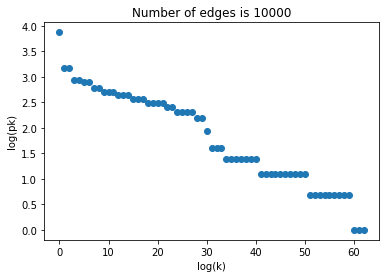

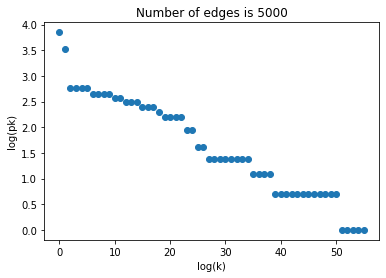

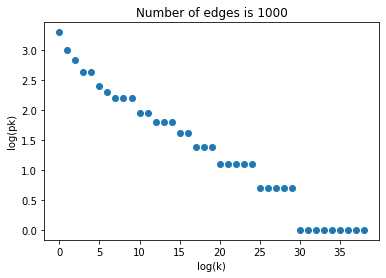

In [9]:
subset_networks = []
for edge in [10000,5000,1000]:
    subset, G = subset_network(tom_df, 0.16, 0.99, edge)
    subset_networks.append(G)
    subset_pivot = subset.pivot('level_0', 'level_1').fillna(0)
    plt.title(f'Number of edges is {edge}')
    scale_free_validate(subset_pivot)

## Evaluation 2: compare network distance by GED and deltacon

## Note to use DeltaCon, the graphs need to have the same number of nodes so just replace edges with small weights with 0

In [10]:
def subset_network2(network_df, weight_min, weight_max):
    '''
    A function to subset a network using weight cutoff
    Return the adjacency matrix and the graph with the edges NOT removed from the cutoff to keep the same # nodes as original graph
    '''
    subset = network_df[(network_df > weight_min) & (network_df < weight_max)]
    subset_adj = subset.stack() # convert from wide to long to determine # edges left
    print('Number of edges left:',len(subset_adj)/2)
    subset = subset.fillna(0)    
    G = nx.convert_matrix.from_pandas_adjacency(subset)
    return subset, G

In [24]:
def compare_graph_distance(network1, network2, metric = 'deltacon'):
    if metric == 'deltacon':
        dist_obj = netrd.distance.DeltaCon()
        return dist_obj.dist(network1, network2)
    else:
        return nx.graph_edit_distance(network1, network2)

In [5]:
def plot_graph_distance(networks, network_names):
    t1 = time.time()
#     dc_distance_list = []
    ged_distance_list = []
    for n in networks:
#         dc_distance_list.append(compare_graph_distance(subset_networks2[0],n))
        ged_distance_list.append(nx.graph_edit_distance(subset_networks[0],n))
    t2 = time.time()
    print('Calculation time:', t2 - t1)
#     plt.subplot(1,2,1)
#     plt.bar(network_names, dc_distance_list)
#     plt.title('Deltacon distance')
#     plt.subplot(1,2,2)
    plt.bar(network_names, ged_distance_list)
    plt.title('GEM distance')

In [34]:
# subset_networks2 = []
# for cutoff in [0.876,0.879]:
#     subset, G = subset_network2(tom_df, cutoff, 0.98)
#     subset_networks2.append(G)

Number of edges left: 22.0
Number of edges left: 20.0


In [6]:
subset_networks = []
for edge in [200,100,50]:
    subset, G = subset_network(tom_df, 0.2, 0.98, edge)
    subset_networks.append(G)

In [ ]:
plot_graph_distance(subset_networks, ['200 edges','100 edges', '50 edges'])